In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Materias2023/Redes/TP1')

import helper

Mounted at /content/drive


# MNIST

In [33]:
from keras.datasets import mnist
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Embedding, concatenate, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import SGD, Adagrad, RMSprop, Adadelta, Adam, Adamax, Nadam

from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc,  roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA



from keras.constraints import max_norm
from keras.initializers import glorot_normal, glorot_uniform, zeros, Constant, normal, he_normal, he_uniform
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
(train_img, full_train_label) , (test_img, test_label) = mnist.load_data()
train_morpho = pd.read_csv("train-morpho.csv")
test_morpho = pd.read_csv("t10k-morpho.csv")

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Normalization
train_img = train_img / 255.0
test_img = test_img / 255.0
for descript in train_morpho:
    if descript != 'index' and descript != 'slant':
        mean = train_morpho[descript].mean()
        var = train_morpho[descript].var()
        train_morpho[descript] = (train_morpho[descript] - mean) / var
for descript in test_morpho:
    if descript != 'index' and descript != 'slant':
        mean = test_morpho[descript].mean()
        var = test_morpho[descript].var()
        test_morpho[descript] = (test_morpho[descript] - mean) / var
        
morpho_data_type = ['area', 'length', 'thickness', 'slant', 'width', 'height']

val_img = train_img[50000:60000,:,:]
val_label = full_train_label[50000:60000]
val_morpho = train_morpho[50000:]
train_img = train_img[0:50000,:,:]
train_label = full_train_label[0:50000]
train_morpho = train_morpho[:50000]

In [5]:
sparse_train_label = np.zeros([train_label.shape[0],10])
sparse_test_label = np.zeros([test_label.shape[0],10])
sparse_val_label = np.zeros([val_label.shape[0],10])

for idx in range(train_img.shape[0]):
   sparse_train_label[idx,train_label[idx]] = 1

for idx in range(test_img.shape[0]):
   sparse_test_label[idx,test_label[idx]] = 1

for idx in range(val_img.shape[0]):
   sparse_val_label[idx,val_label[idx]] = 1

####1 - EDA

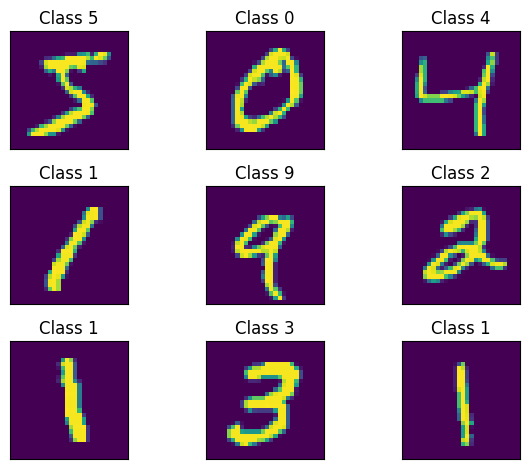

In [6]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_img[i])
    plt.title("Class " + str(train_label[i])) 
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [7]:
train_morpho

,index,area,length,thickness,slant,width,height
0,0,0.003610,0.053510,-0.371137,0.231074,0.095935,0.545724
1,1,0.017218,0.060717,-0.039510,0.331858,0.151451,0.172372
2,2,-0.021099,0.019957,-1.581313,-0.212196,0.484707,0.006148
3,3,-0.030545,-0.158508,0.605208,0.509185,-0.504976,0.454257
4,4,-0.010159,0.022715,-0.824599,0.007590,0.013199,0.309417
...,...,...,...,...,...,...,...
49995,49995,0.008199,0.049975,-0.373262,-0.284491,-0.026185,0.561871
49996,49996,-0.007170,0.144591,-1.860622,0.211029,0.381412,-1.099845
49997,49997,-0.009252,0.074856,-1.244754,-0.134999,-0.231092,0.434199
49998,49998,-0.011653,-0.003242,-0.626520,0.025046,-0.225883,0.146863


#####Distribución de clases

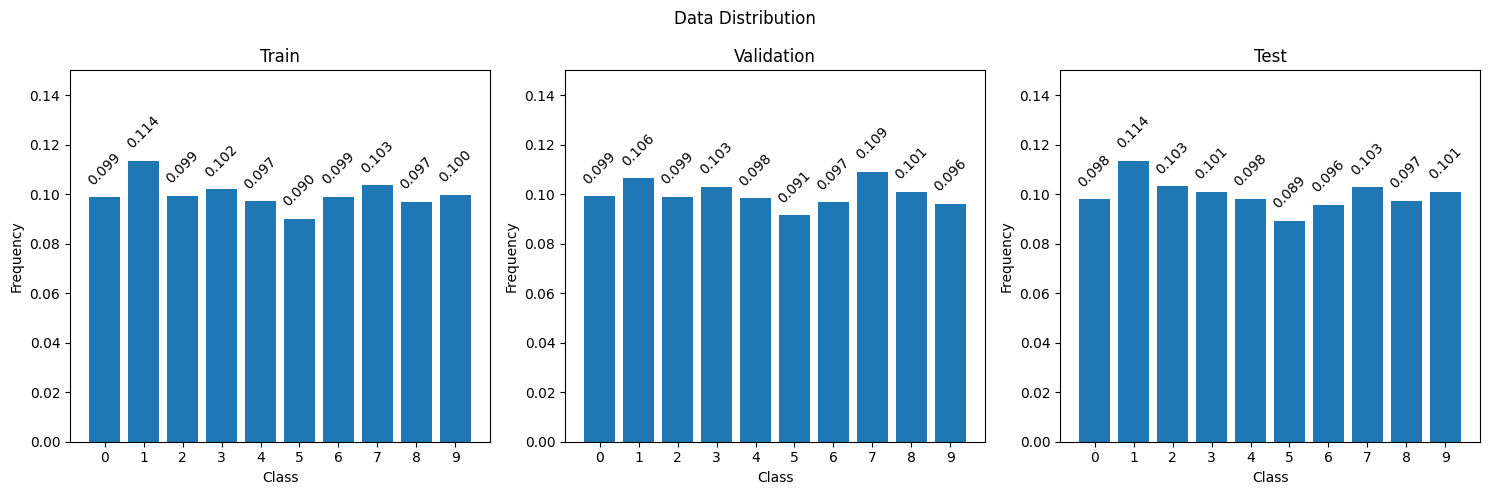

In [ ]:
# Calcular la frecuencia de cada clase
train_freq = np.bincount(train_label)/50000
val_freq = np.bincount(val_label)/10000
test_freq = np.bincount(test_label)/10000

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
def EDAGraph (freq, ax, title):
    ax.bar(class_names, freq)
    ax.set_xlabel('Class')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.set_xticks(range(len(class_names)))
    ax.set_ylim([0, 0.15]) 
    ax.set_xticklabels(class_names)

    for i in range(len(class_names)):
        ax.text(i, freq[i] + 0.005, f"{freq[i]:.3f}", rotation=45, ha='center')

EDAGraph(train_freq, ax1, 'Train')
EDAGraph(val_freq, ax2, 'Validation')
EDAGraph(test_freq, ax3, 'Test')

plt.suptitle('Data Distribution')
plt.tight_layout()
plt.show()

Se puede observar que las **clases** se encuentran **balanceadas**, aunque no tanto como en el caso de Fashion-MNIST.

#####Histogramas de descriptores morfológicos

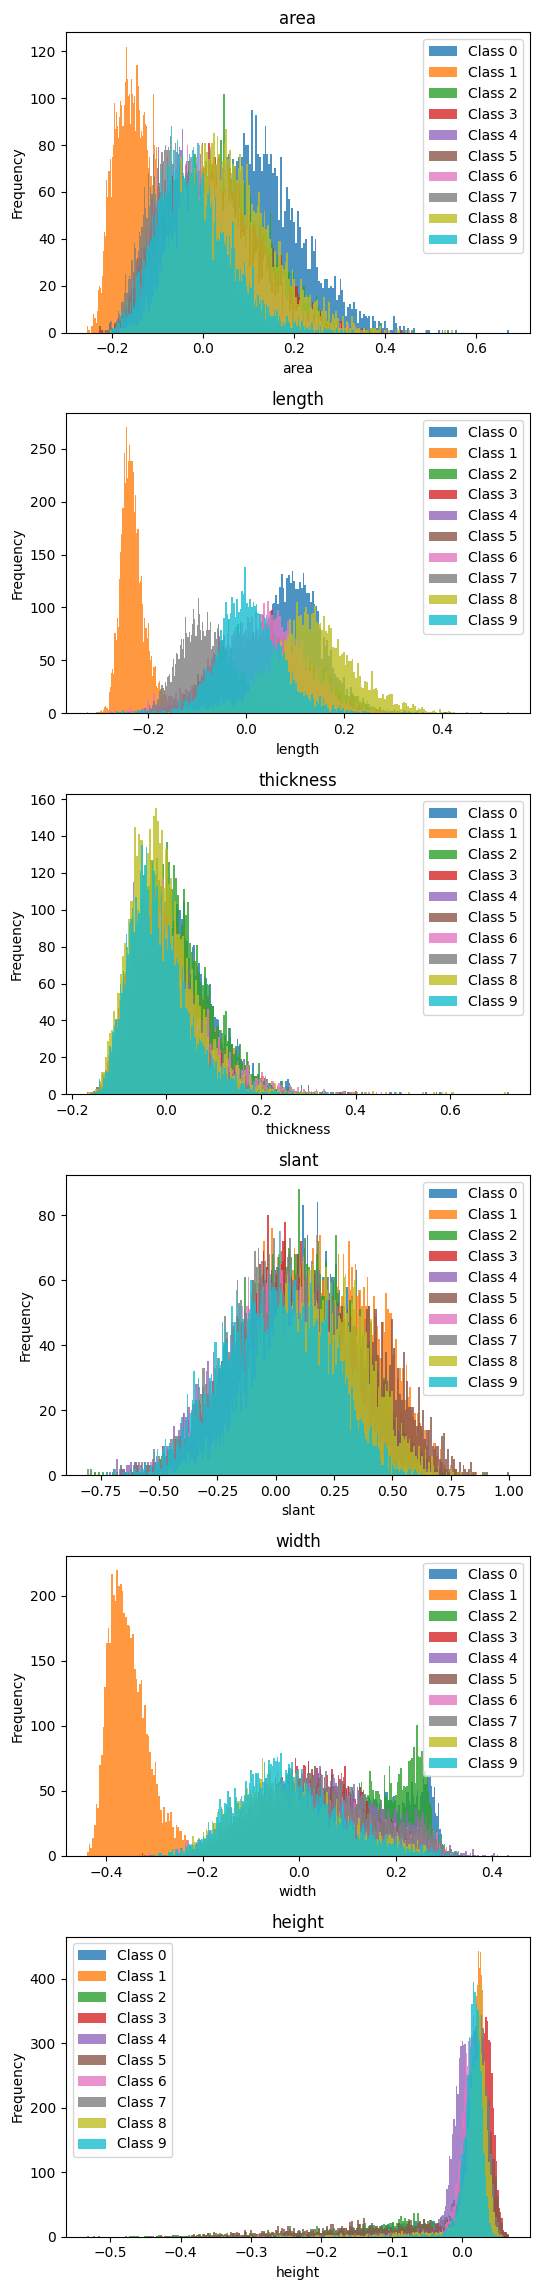

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig, axs = plt.subplots(len(morpho_data_type), figsize=(5.5, 23))

#Sobre cada atributo morfológico
for i, data in enumerate(morpho_data_type):
    ax = axs[i]
    ax.set_title(data)
    ax.set_xlabel(data)
    ax.set_ylabel('Frequency')

    for number in range(10):
        subset = train_morpho[train_label == number]
        ax.hist(subset[data], bins=200, alpha=0.8, color=colors[number], label=f'Class {number}')

    ax.legend()

plt.tight_layout()
plt.show()

Se puede observar que algunos parámetros como *area* y *length* son mas distinguibles por clase que otros como el *thikness* o *height*.

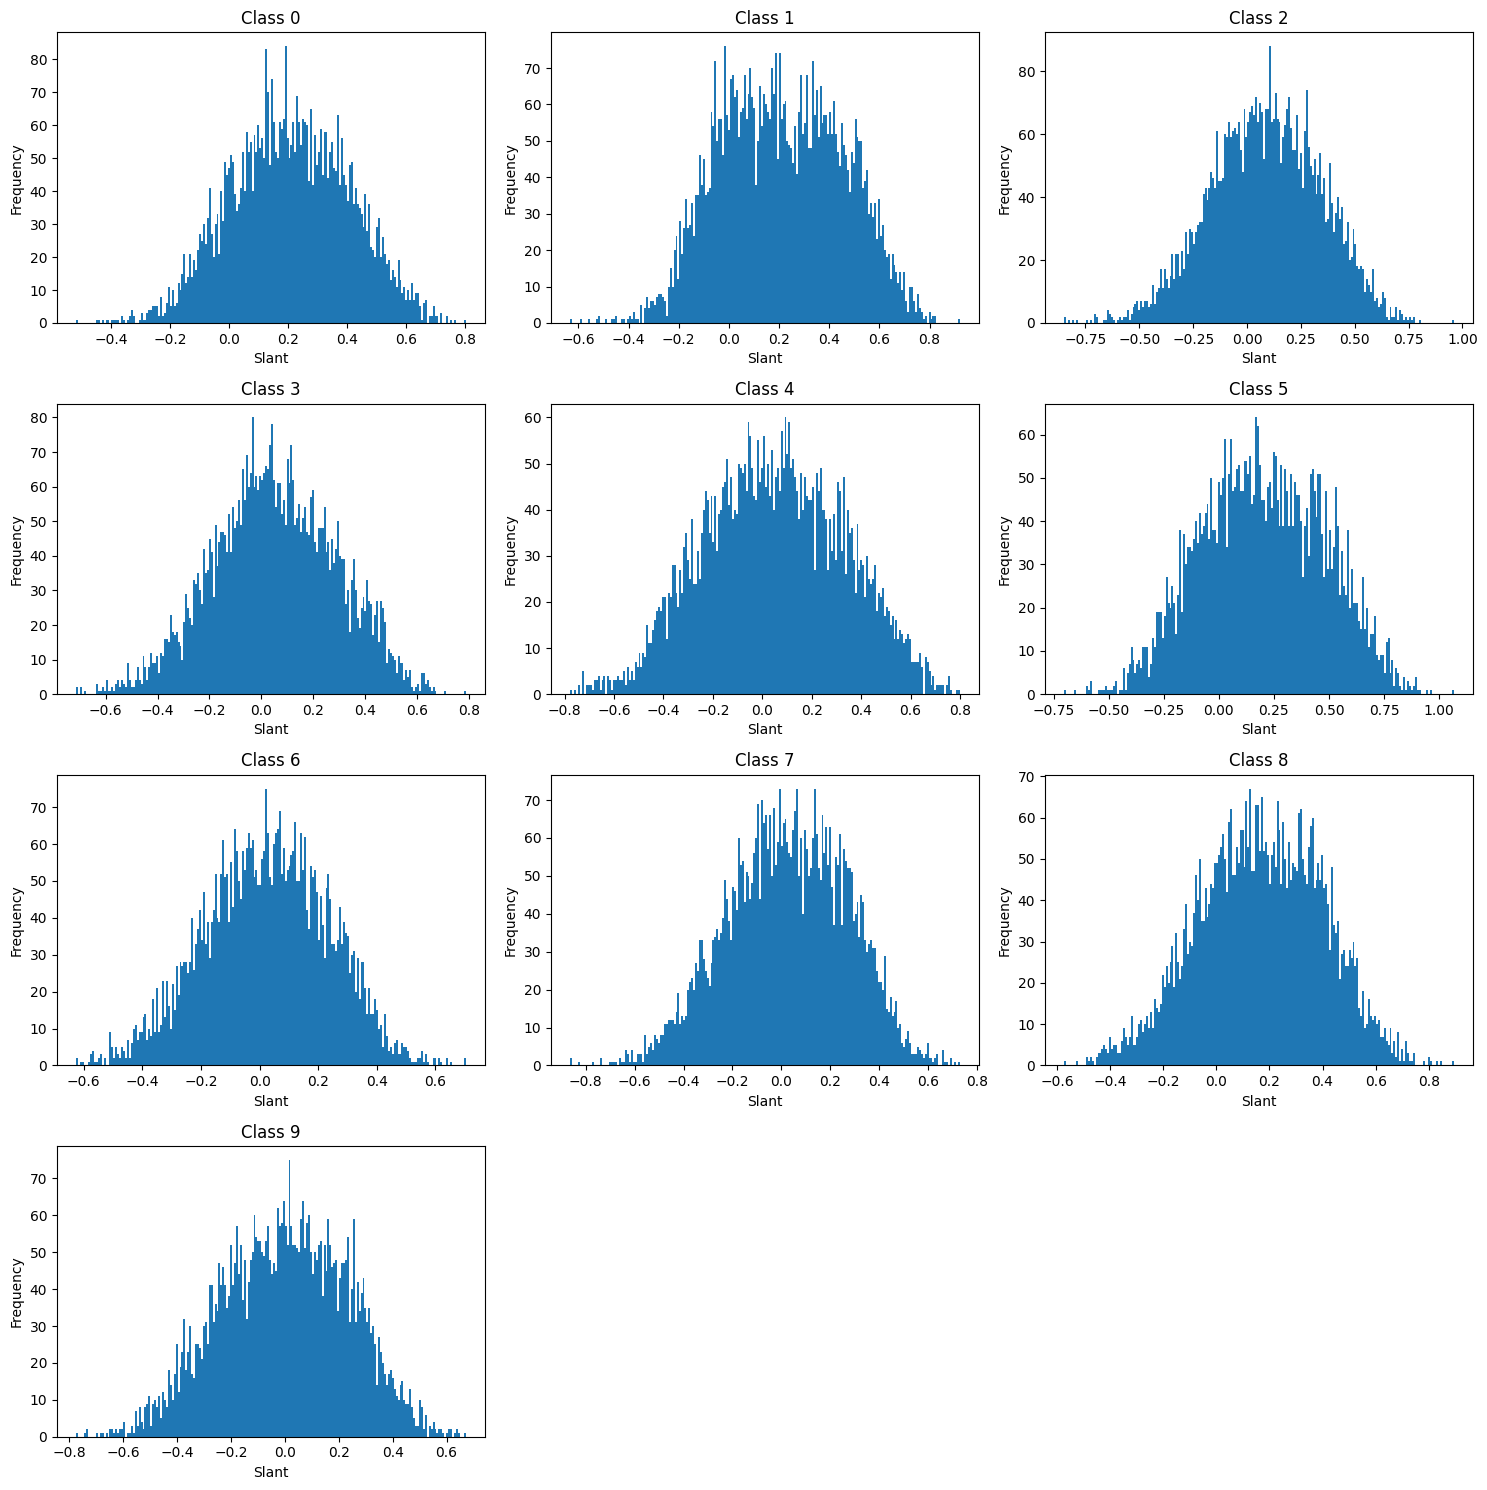

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

for number in range(10):
    row = number // 3
    col = number % 3
    ax = axs[row, col]
    ax.set_title('Class ' + str(number))
    ax.set_xlabel('Slant')
    ax.set_ylabel('Frequency')

    subset = train_morpho[train_label == number]
    ax.hist(subset['slant'], bins=200)

# Eliminar los gráficos vacíos
plt.delaxes(axs[3, 1])
plt.delaxes(axs[3, 2])


plt.tight_layout()
plt.show()


#####Scatters de inclinación vs otros descriptores morfológicos

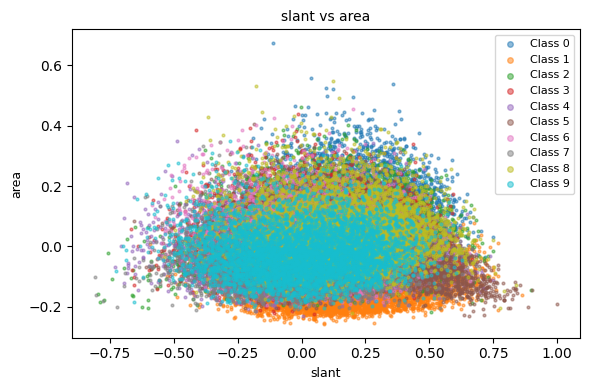

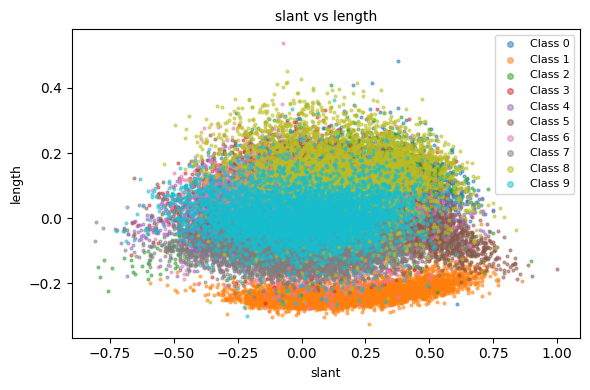

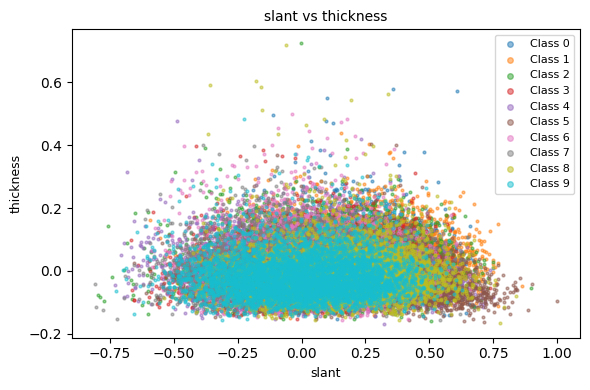

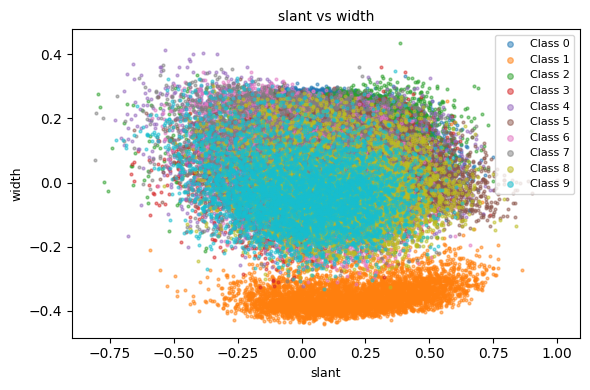

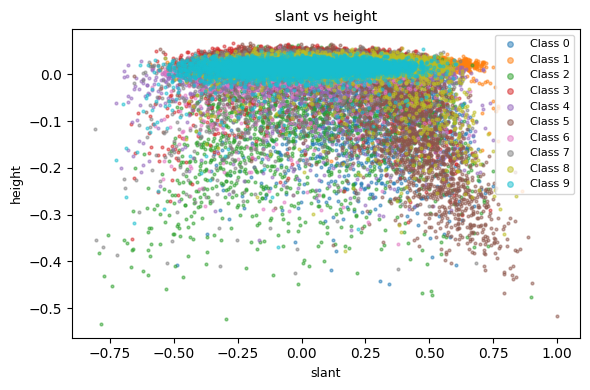

In [ ]:
for data in morpho_data_type:
    if(data!='slant'):
        plt.figure(figsize=(6, 4))
        for number in range(10):
            subset = train_morpho[train_label == number]
            plt.scatter(subset['slant'], subset[data], color=colors[number], alpha=0.5, s=4, label=f'Class {number}')
    
        plt.title(f'slant vs {data}', fontsize=10)
        plt.xlabel('slant', fontsize=9)
        plt.ylabel(data, fontsize=9)
        
        plt.legend(markerscale=2, fontsize = 8)
        plt.tight_layout()
        plt.show()

A simple vista parece complicado determinar la correlación entre los descriptores. Por lo tanto se optó por calcularlo

#####Correlación

In [ ]:
for descript in train_morpho:
    if descript != 'index' and descript != 'slant':
        corr = train_morpho['slant'].corr(train_morpho[descript])
        print('Correlación entre', descript, 'y slant es:', corr)

Correlación entre area y slant es: 0.0037217590781525238
Correlación entre length y slant es: -0.0208426302496089
Correlación entre thickness y slant es: 0.01971091416570556
Correlación entre width y slant es: -0.15296675189764494
Correlación entre height y slant es: -0.1498467332096925


Se puede notar que los descriptores que **mayor correlación** tiene con el slant son el **width** y el **height**

##2 - Modelos

###Predictor de número

In [ ]:
model = Sequential()
learning_rate = 0.00125
batch_size= 128
optimizer = Adam
activation = 'relu'
dropout_rate = 0.2
batch_normalization = False
weight_init = 'glorot_normal'
epochs=10

model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(512, activation = activation, kernel_initializer = weight_init))
model.add(Dropout(dropout_rate))
model.add(Dense(256, activation = activation, kernel_initializer = weight_init))
model.add(Dropout(dropout_rate))

if (batch_normalization): model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer= optimizer (learning_rate=learning_rate), metrics=['accuracy'])
history = model.fit(train_img, sparse_train_label, validation_data=(val_img, sparse_val_label), epochs=epochs, batch_size = batch_size)



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dense_31 (Dense)            (None, 512)               401920    
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-t

###A- En función de la imagen

In [ ]:
def model (model, learning_rate = 0.001, batch_size= 256, optimizer = Adam, activation = 'relu', dropout_rate = 0.1, batch_normalization = True, weight_init = 'glorot_normal', verbose = True):

    epochs=20

    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(512, activation = activation, kernel_initializer = weight_init))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation = activation, kernel_initializer = weight_init))
    model.add(Dropout(dropout_rate))

    if (batch_normalization): model.add(BatchNormalization())

    model.add(Dense(1, activation='linear'))

    if (verbose): model.summary()

    model.compile(loss='mean_absolute_error', optimizer= optimizer (learning_rate=learning_rate), metrics=['mae'])
    history = model.fit(train_img, train_morpho["slant"], validation_data=(val_img, val_morpho["slant"]), epochs=epochs, batch_size = batch_size, verbose=verbose)
    
    return history

In [ ]:
model_base= Sequential()
model(model_base)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                      

In [ ]:
loss, mae = model_base.evaluate(test_img, test_morpho["slant"])

313/313 [==============================] - 1s 2ms/step - loss: 0.0149 - mae: 0.0149


Se puede notar que **el MAE es pequeño**. El **MSE es menor** (lo cual tiene sentido, ya que los valores estarán elevados al cuadrado), pero debido a que la métrica a reportar es el MAE se optó por solo mostrar esta última.

Se fueron variando los diferentes hiperparámetros, de a uno a la vez. Por cada variación se fue **preservando el mejor valor** de los hiperparámetros anteriores. Se graficó la cantidad de epochs y el **MAE de validation**.

####Variación de Learning Rate

In [ ]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

print('Learning Rate','\t', 'Loss','\t\t', 'MAE')

for i in range(4):
    mymodel = Sequential()
    model(mymodel, learning_rates[i], verbose = False)
    loss, mae = mymodel.evaluate(test_img, test_morpho["slant"], verbose=False)
    print (learning_rates[i], '\t\t', round(loss,4), '\t', round(mae,4))

Learning Rate 	 Loss 		 MAE
0.0001 		 0.0249 	 0.0249
0.001 		 0.0113 	 0.0113
0.01 		 0.0209 	 0.0209
0.1 		 0.1002 	 0.1002


Con learning rates muy pequeños o muy grandes el MAE aumenta, debido a la lentitud o el exceso del avance de aprendizaje. Por eso se optó por utilizar un learning rate óptimo intermedio de 0.001.

####Variación de Batch Size

In [ ]:
batch_size = [16, 64, 128, 256, 512]

print('Batch Size','\t', 'Loss','\t\t', 'MAE')

for i in range(5):
    mymodel = Sequential()
    model(mymodel, batch_size = batch_size[i], learning_rate=0.001, verbose = False)
    loss, mae = mymodel.evaluate(test_img, test_morpho["slant"], verbose=False)
    print (batch_size[i], '\t\t', round(loss,4), ' \t', round(mae,4))

Batch Size 	 Loss 		 MAE
16 		 0.0163  	 0.0163
64 		 0.0318  	 0.0318
128 		 0.0113  	 0.0113
256 		 0.011  	 0.011
512 		 0.0169  	 0.0169


Ocurre lo mismo que con el learning rate, optándose por utilizar un batch size óptimo intermedio de 256.

####Variación de Optimizadores

In [ ]:
optim = [Adadelta, SGD, Adagrad, Adam, Adamax, RMSprop, Nadam]
optim_n = ['Adadelta', 'SGD    ', 'Adagrad', 'Adam    ', 'Adamax  ', 'RMSprop', 'Nadam   ']

print('Optimizer','\t\t', 'Loss','\t\t', 'MAE')

for i in range(7):
    mymodel = Sequential()
    model(mymodel, optimizer = optim[i], batch_size = 256, learning_rate=0.001, verbose = False)
    loss, mae = mymodel.evaluate(test_img, test_morpho["slant"], verbose=False)
    print (optim_n[i], '\t\t', round(loss,4), ' \t', round(mae,4))

Optimizer 		 Loss 		 MAE
Adadelta 		 0.3096  	 0.3096
SGD     		 0.0489  	 0.0489
Adagrad 		 0.0686  	 0.0686
Adam     		 0.0196  	 0.0196
Adamax   		 0.0103  	 0.0103
RMSprop 		 0.0215  	 0.0215
Nadam    		 0.028  	 0.028


Adadelta, SGD y Argad no son buenos optimizadores para este modelo debido a su alto MAE. El resto es aceptable, y se optó por utilizar Adamax, ya que es el que menor MAE produjo.

####Variación de Activaciones

In [ ]:
activation = ['sigmoid', 'tanh', 'softplus', 'elu', 'selu', 'relu', 'leaky_relu', 'softmax']
activation_n = ['sigmoid', 'tanh   ', 'softplus', 'elu    ', 'selu   ', 'relu    ', 'l_relu   ', 'softmax']

print('Activation','\t\t', 'Loss','\t\t', 'MAE')

for i in range(8):
    mymodel = Sequential()
    model(mymodel, activation = activation[i], optimizer = Adamax, batch_size = 256, learning_rate=0.001, verbose = False)
    loss, mae = mymodel.evaluate(test_img, test_morpho["slant"], verbose=False)
    print (activation_n[i], '\t\t', round(loss,4), '  \t', round(mae,4))

Activation 		 Loss 		 MAE
sigmoid 		 0.0126   	 0.0126
tanh    		 0.014   	 0.014
softplus 		 0.0206   	 0.0206
elu     		 0.0099   	 0.0099
selu    		 0.0088   	 0.0088
relu     		 0.0233   	 0.0233
l_relu    		 0.0135   	 0.0135
softmax 		 0.0085   	 0.0085


En su mayoría parecen ser todas buenas funciones de activación para este modelo. Sin embargo, se puede notar una gran mejora de la sigmoidea respecto a otras. A pesar de esto, se selecciónó la softmax, debido a que fue la de menor MAE en la mayoría de las iteraciones que se llevaron a cabo.

####Variación de Drop Out

In [ ]:
drop_out = [0.1, 0.2, 0.3, 0.6]

print('Drop Out','\t', 'Loss','\t\t', 'MAE')

for i in range(4):
    mymodel = Sequential()
    model(mymodel, dropout_rate = drop_out[i], activation = 'softmax', optimizer = Adamax, batch_size = 256, learning_rate=0.001, verbose = False)
    loss, mae = mymodel.evaluate(test_img, test_morpho["slant"], verbose=False)
    print (drop_out[i], '\t\t', round(loss,4), ' \t', round(mae,4))

Drop Out 	 Loss 		 MAE
0.1 		 0.0088  	 0.0088
0.2 		 0.0087  	 0.0087
0.3 		 0.0117  	 0.0117
0.6 		 0.0165  	 0.0165


Si bien es necesario un valor de drop out elevado para que entrenen todas las neuronas, un valor demasiado elevado terminará perjudicando al sistema. Es por esto que se optó por un dropout de 0.2 que tiene un bajo MAE.

####Variación de Inicialización de Pesos

In [ ]:
weight_init = ['glorot_normal', 'glorot_uniform', Constant(0.5), normal(0,1,seed=42), 'he_normal', 'he_uniform', 'zeros']
weight_init_n = ['glorot_normal', 'glorot_uniform', 'Constante 0.5', 'Normal~(0,1)', 'he_normal', 'he_uniform', 'zeros   ']

print('Weigth Init','\t\t', 'Loss','\t\t', 'MAE')

for i in range(7):
    mymodel = Sequential()
    model(mymodel, weight_init = weight_init[i], dropout_rate=0.2, activation = 'softmax', optimizer = Adamax, batch_size = 256, learning_rate=0.001, verbose = False)
    loss, mae = mymodel.evaluate(test_img, test_morpho["slant"], verbose=False)
    print (weight_init_n[i], '\t\t', round(loss,4), ' \t', round(mae,4))

Weigth Init 		 Loss 		 MAE
glorot_normal 		 0.0107  	 0.0107
glorot_uniform 		 0.0104  	 0.0104
Constante 0.5 		 0.0076  	 0.0076
Normal~(0,1) 		 0.0744  	 0.0744
he_normal 		 0.0151  	 0.0151
he_uniform 		 0.0122  	 0.0122
zeros    		 0.0126  	 0.0126


Con excepción de la normal, el resto de las inicializaciones de pesos demostraron ser útiles para éste modelo. A pesar de que la constante 0.5 tiene el menor valor de MAE, se optó por utilizar glorot normal ya que era aquella inicialización la que había demostrado solidez en las diferentes iteraciones.

In [ ]:
best_model = Sequential()
model(best_model, weight_init = 'glorot_normal', dropout_rate=0.2, activation = 'softmax', optimizer = Adamax, batch_size = 256, learning_rate=0.001, verbose = False)
loss, mae = best_model.evaluate(test_img, test_morpho["slant"])

313/313 [==============================] - 1s 2ms/step - loss: 0.0107 - mae: 0.0107


A pesar de que no se graficaron los valores de los distintos hiperparámetros, fueron mostrados de manera cuantitativa. Éstos permitieron **mejorar** al modelo **respecto al original**.

###B - En función de la imagen y el label

In [48]:
def modelB(learning_rate=0.001, batch_size=256, optimizer=Adamax, activation='softmax', dropout_rate=0.2, batch_normalization=True, weight_init='glorot_normal', verbose=True):
    epochs = 20
    
    # Defino las 2 entradas
    img_input = Input(shape=(28, 28))
    label_input = Input(shape=(10,))
    
    # Para la imagen
    x = Flatten()(img_input)
    
    # Capas de la red para label
    y = Embedding(input_dim=10, output_dim=2, input_length=1)(label_input)
    y= Flatten()(y)
    
    # Concatenar la salidas de las capas
    concatenated = concatenate([x, y])
    
    
    z = Dense(512, activation=activation, kernel_initializer=weight_init)(concatenated)
    z = Dropout(dropout_rate)(z)
    z = Dense(256, activation=activation, kernel_initializer=weight_init)(z)
    z = Dropout(dropout_rate)(z)

    if batch_normalization:
        z = BatchNormalization()(z)

    output = Dense(1, activation='linear')(z)
    
    model = Model(inputs=[img_input, label_input], outputs=output)
    
    if verbose:
        model.summary()

    model.compile(loss='mean_absolute_error', optimizer=optimizer(learning_rate=learning_rate), metrics=['mae'])
    
    # Entrenar el modelo
    history = model.fit([train_img, sparse_train_label], train_morpho["slant"], validation_data=([val_img, sparse_val_label], val_morpho["slant"]), epochs=epochs, batch_size=batch_size, verbose=verbose)

    return model

bmodel = modelB(learning_rate=0.001, batch_size=256, optimizer=Adamax, activation='softmax', dropout_rate=0.2, batch_normalization=True, weight_init='glorot_uniform', verbose=True)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 10, 2)        20          ['input_30[0][0]']               
                                                                                                  
 flatten_26 (Flatten)           (None, 784)          0           ['input_29[0][0]']               
                                                                                           

In [35]:
test_label_encoded = to_categorical(test_label)
loss, mae = bmodel.evaluate([test_img, test_label_encoded], test_morpho["slant"])

313/313 [==============================] - 1s 2ms/step - loss: 0.0103 - mae: 0.0103


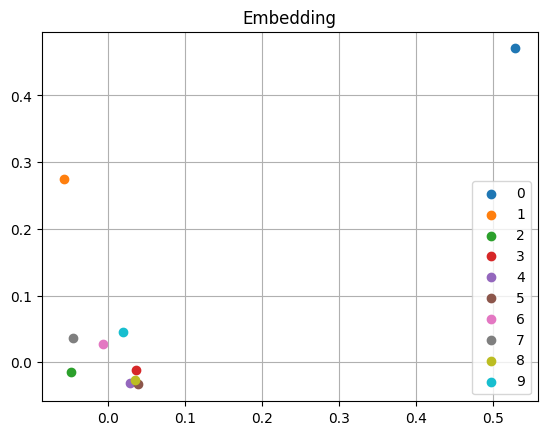

In [66]:
def embeddings_plt(vectors):
    for index in range(len(vectors)):
        x_coordinate = vectors[index][0]
        y_coordinate = vectors[index][1]
        label =index
        plt.scatter(x=x_coordinate, y=y_coordinate, label=label)

    plt.title("Embedding")
    plt.legend()
    plt.grid()
    plt.show()

embedding_weights = bmodel.get_layer('embedding_12').get_weights()[0]
embeddings_plt(embedding_weights)

Se puede notar como tanto el 0 como el 1 son los mas distinguibles por el slant. Sin embargo el resto de los números se encuentra muy cercanos, en especial el 4, 8 y 5. Esto es llamativo ya que esos números no presentan mucha similitud.


###C - En función de la imagen y width

Se optó por utilizar el *Width* ya que es la variable contínua con mayor correlación, tal como se probó anteriormente.

In [79]:
def modelC(learning_rate=0.001, batch_size=256, optimizer=Adamax, activation='softmax', dropout_rate=0.2, batch_normalization=True, weight_init='glorot_normal', verbose=True):
    epochs = 20
    
    # Defino las 2 entradas
    img_input = Input(shape=(28, 28))
    width_input = Input(shape=(1,))
    
    # Para la imagen
    x = Flatten()(img_input)
    
    # Para el width
    y = width_input

    # Concatenar la salidas de las capas
    concatenated = concatenate([x, y])

    z = Dense(256, activation=activation, kernel_initializer=weight_init)(concatenated)
    z = Dropout(dropout_rate)(z)
    z = Dense(128, activation=activation, kernel_initializer=weight_init)(z)
    z = Dropout(dropout_rate)(z)

    if batch_normalization:
        z = BatchNormalization()(z)
    
    concatenated = concatenate([x, y])
    output = Dense(1, activation='linear')(z)
    
    model = Model(inputs=[img_input, width_input], outputs=output)
    
    if verbose:
        model.summary()

    model.compile(loss='mean_absolute_error', optimizer=optimizer(learning_rate=learning_rate), metrics=['mae'])
    history = model.fit([train_img, train_morpho['width']], train_morpho["slant"], validation_data=([val_img, val_morpho['width']], val_morpho["slant"]), epochs=epochs, batch_size=batch_size, verbose=verbose)
   
    return model

cmodel = modelC(learning_rate=0.001, batch_size=256, optimizer=Adamax, activation='softmax', dropout_rate=0.2, batch_normalization=True, weight_init='glorot_uniform', verbose=True)


Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_32 (Flatten)           (None, 784)          0           ['input_37[0][0]']               
                                                                                                  
 input_38 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 concatenate_20 (Concatenate)   (None, 785)          0           ['flatten_32[0][0]',             
                                                                  'input_38[0][0]']        

In [80]:
loss, mae = cmodel.evaluate([test_img, test_morpho['width']], test_morpho["slant"])

313/313 [==============================] - 1s 2ms/step - loss: 0.0109 - mae: 0.0109


Se puede notar que el resultado obtenido fue similar respecto al obtenido en el modelo del punto A. Esto se debe a que los hiperparámetros fueron específicamente seleccionados para ese modelo y no para este último. Sin embargo se puede ver una mejora, debido a que en éste último modelo se redujo el número de nouronas a la mitad.
Sin embargo la diferencia sigue sin ser grande, debido a la baja correlación.